# The V Model under the unifie Master equation

We will first consider a simple implementation of the V model with a jump unravelling for a single bath. We will consider the model that is explicity studied in 

https://arxiv.org/pdf/2212.11307.pdf

The Hamiltonian of this model is a 3 level system given by 
\begin{equation}
    H = (\nu - \Delta)\ket{2}\bra{2} + \nu \ket{3}\bra{3}\,,
\end{equation}
where $\nu$ is the energy level and $\Delta$ parameterises the degeneracy between the two levels. 
There are two extreme limits in this model; the first corresponding to the Unified master equation which occurs when $\Delta$ is very small, and the the Secular approximation when $\Delta$ is larger. 

In the former case we will have two dissipators acting on the system coupled to the Left reservoir
\begin{equation}
    L_{-} = \gamma(\nu)(\ket{1}\bra{2} + \ket{1}\bra{3}) \quad \text{and} \quad L_{+} = \gamma(-\nu)(\ket{2}\bra{1} + \ket{3}\bra{1})\,,
\end{equation}
where $\gamma(\omega) = \mathcal{J}(\omega)[n(\omega)+1]$ and $\gamma(-\omega) =  \mathcal{J}(\omega)n(\omega)$ are the dissipation rates of the downward and upward channels respectively, $\mathcal{J}(\omega)= a \omega$ is a Ohmic spectral density, and $n(\omega ) = (e^{\beta \omega} - 1)^{-1}$ is the Bose-Einstein distribution. 
We will further have the two dissipators coupling to the Right reservoir given by 
\begin{equation}
    R_{-} = \gamma(\nu)(\ket{1}\bra{2} + \alpha \ket{1}\bra{3}) \quad \text{and} \quad R_{+} = \gamma(-\nu)(\ket{2}\bra{1} + \alpha \ket{3}\bra{1})\,,
\end{equation}
Under the Unified master equation (Eq. 10 in the paper) these clustered noise operators can be rewritten in the Schrodinger picture using a slight change of basis in the following form 
\begin{equation}
    \frac{d \rho}{dt} = -i[H, \rho] + \mathcal{D}[L_{-}]\rho + \mathcal{D}[L_{+}]\rho +  \mathcal{D}[R_{-}]\rho + \mathcal{D}[R_{+}]\rho \,.
\end{equation}
Given that we have this in Lindblad form, we can easily write this as an unravelled master equation for quantum jumps, where we associate a jump with either $L_{-}$ or $L_{+}$. It is important to note that these jumps do not distinguish which transition the jump came from i.e ($\ket{1}\bra{2}$ or $\ket{1}\bra{3}$) thus erasing any 'which way' information.

We will also study the Secular approximation, which holds in the limit of large $\Delta$. Under this approximation, the left hand operators are split into 

### Using Qutip
To build up a simple model to study this system we will use the python package qutip which makes this relatively simple to simulate. 

In [18]:
import numpy as np
from qutip import *
import matplotlib.pyplot as plt
from FCS import *
from _utils import *

def TiltedLiouvillain(H, c_ops, nu_k, chi):
    """
    Returns the tilted Liouvillain for the system.
    """
    # Use the qutip function to get the Liouvillian given a Hamiltonian and collapse operators
    L = liouvillian(H, c_ops)

    # Add the tilted collapse operators
    Lk = sum([(np.exp(-1j*nu_k[k]*chi)-1) * to_super(c_ops[k]) for k in range(len(c_ops))])

    # Add the tilted collapse operators and turn them into a numpy array using .full()
    Lchi = (L + Lk).full()
    return Lchi

def SCGF(H, c_ops, nu_k, chi):
    """
    Returns the scaled cumulant generating function for the tilted Liouvillain
    """
    # Get the tilted Liouvillain numpy array
    Lchi = TiltedLiouvillain(H, c_ops, nu_k, chi)

    # Compute eigenvalues of Lchi
    eigs = np.linalg.eigvals(Lchi)

    # Return the maximum eigenvalue with the maximum real part
    return eigs[np.argmax(np.real(eigs))]

def BoseEinsteinDistribution(omega, beta):
    """
    Returns the Bose-Einstein distribution for the given frequency and temperature
    """
    return 1/(np.exp(omega*beta)-1)

def rates(a, omega, beta, kind='down'):
    """
    Returns the rates for the given frequency and temperature for an Ohmic bath
    """
    if kind=='down':
        return a * omega * (BoseEinsteinDistribution(omega, beta) + 1)
    elif kind=='up':
        return a * omega * BoseEinsteinDistribution(omega, beta)

In [26]:
# Define system parameters
N = 3 # Number of levels
nu = 1 # Frequency of the system
a = 0.02
delta = 0.01
alpha = 0.5
betaL = 1/4
betaR = 1/3

# Defin system rates left bath Unified
gamma_Lm = rates(a, nu, betaL, kind='down')
gamma_Lp = rates(a, nu, betaL, kind='up')
gamma_Rm = rates(a, nu, betaR, kind='down')
gamma_Rp = rates(a, nu, betaR, kind='up')

#Deine system rates left bath Secular
gamma_Lm2 = rates(a, nu - delta, betaL, kind='down')
gamma_Lp2 = rates(a, nu - delta, betaL, kind='up')
gamma_Rm2 = rates(a, nu - delta, betaR, kind='down')
gamma_Rp2 = rates(a, nu - delta, betaR, kind='up')
gamma_Lm3 = rates(a, nu, betaL, kind='down')
gamma_Lp3 = rates(a, nu, betaL, kind='up')
gamma_Rm3 = rates(a, nu, betaR, kind='down')
gamma_Rp3 = rates(a, nu, betaR, kind='up')

# Define system operators
g1 = fock(3, 0)
g2 = fock(3, 1)
g3 = fock(3, 2)

# Define Hamiltonian
H =(nu - delta) * g2 * g2.dag() + nu * g3 * g3.dag()

H_eigs = H.eigenenergies()

# Define collapse operators Unified
# LLm = np.sqrt(gamma_Lm) * (g1 * g2.dag() + g1 * g3.dag())/np.sqrt(2)
# LLp = np.sqrt(gamma_Lp) * (g2 * g1.dag() + g3 * g1.dag())/np.sqrt(2)
# LRm = np.sqrt(gamma_Rm) * (g1 * g2.dag() + alpha * g1 * g3.dag())
# LRp = np.sqrt(gamma_Rp) * (g2 * g1.dag() + alpha * g3 * g1.dag())

# Re - define collapse operators to ensure there's no weirdness going on with the rates being mismatched
LLm = np.sqrt(gamma_Lm) * (g1 * g2.dag() + g1 * g3.dag())/np.sqrt(2)
LLp = np.sqrt(gamma_Lp) * (g2 * g1.dag() + g3 * g1.dag())/np.sqrt(2)
LRm = np.sqrt(gamma_Rm) * (g1 * g2.dag() + alpha * g1 * g3.dag())/np.sqrt(1 + alpha**2)
LRp = np.sqrt(gamma_Rp) * (g2 * g1.dag() + alpha * g3 * g1.dag())/np.sqrt(1 + alpha**2)


# Define collapse operators Secular
LLm1 = np.sqrt(gamma_Lm2) * (g1 * g2.dag())
LLm2 = np.sqrt(gamma_Lm3) * (g1 * g3.dag())
LLp1 = np.sqrt(gamma_Lp2) * (g2 * g1.dag())
LLp2 = np.sqrt(gamma_Lp3) * (g3 * g1.dag())
LRm1 = np.sqrt(gamma_Rm2) * (g1 * g2.dag())
LRm2 = np.sqrt(gamma_Rm3) * (alpha * g1 * g3.dag())
LRp1 = np.sqrt(gamma_Rp2) * (g2 * g1.dag())
LRp2 = np.sqrt(gamma_Rp3) * (alpha * g3 * g1.dag())

# Define a list collapse operators
c_ops_Unified = [LLm, LLp, LRm, LRp]
c_ops_Secular = [LLm1, LLm2, LLp1, LLp2, LRm1, LRm2, LRp1, LRp2]

# Compute the steady state in either limit
rho_ss_uni = steadystate(H, c_ops_Unified)
rho_ss_sec = steadystate(H, c_ops_Secular)

In [27]:
# Now we want to compute the largest eigenvalue of the tilted Liouvillain
chi_list = np.linspace(-np.pi, np.pi, 100)
eigs_chi = np.zeros(len(chi_list), dtype=complex)

# Define coefficients for the particle current of J_L
nu_k = [nu, -nu, 0, 0]
for i, chi in enumerate(chi_list):
    eigs_chi[i] = SCGF(H, c_ops_Unified, nu_k, chi)

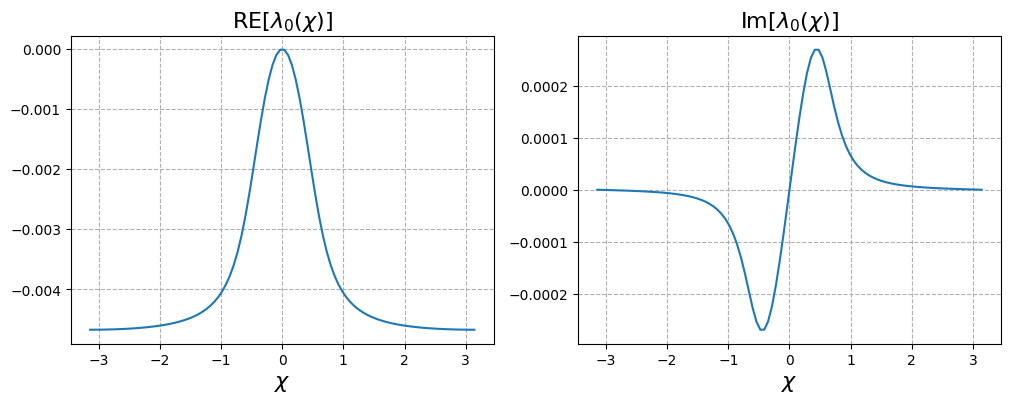

In [28]:
fig = plt.figure(figsize=(12, 4))

plt.subplot(121)
plt.plot(chi_list, np.real(eigs_chi))
plt.grid(linestyle='--')
plt.xlabel(r'$\chi$', fontsize=16)
plt.title('Real part of the largest eigenvalue', fontsize=16)
plt.title(r'${\rm RE}[\lambda_{0}(\chi)]$', fontsize=16)

plt.subplot(122)
plt.plot(chi_list, np.imag(eigs_chi))
plt.grid(linestyle='--')
plt.xlabel(r'$\chi$', fontsize=16)
plt.title(r'${\rm Im}[\lambda_{0}(\chi)]$', fontsize=16)

plt.show()

In [33]:
# Now we to unravel the master equation 
t0, tf = 0, 300
dt = 0.01
tlist = np.arange(t0, tf, dt)

# define observables 
e_ops = [g1*g1.dag(), g2*g2.dag(), g3*g3.dag(), g3*g2.dag(), g2*g3.dag()]

rho_init = g1*g1.dag()

# compute the solution, here the options ntraj is the number of trajectories and noise is the seed, store_measurement saves the jumps
result_uni = photocurrent_mesolve(H, rho_init, tlist, sc_ops=c_ops_Unified, e_ops=e_ops, ntraj=1, noise=1, store_measurement=True)
result_sec = photocurrent_mesolve(H, rho_init, tlist, sc_ops=c_ops_Secular, e_ops=e_ops, ntraj=1, noise=1, store_measurement=True)

Total run time:   0.59s
Total run time:   0.81s


In [34]:
# Get all the expectation values
g1_evo_uni = result_uni.expect[0]
g2_evo_uni = result_uni.expect[1]
g3_evo_uni = result_uni.expect[2]
g32_evo_uni = result_uni.expect[3]
g23_evo_uni = result_uni.expect[4]
purity_uni = g1_evo_uni**2 + g2_evo_uni**2 + g3_evo_uni**2 + 2*g32_evo_uni*g23_evo_uni

g1_evo_sec = result_sec.expect[0]
g2_evo_sec = result_sec.expect[1]
g3_evo_sec = result_sec.expect[2]
g32_evo_sec = result_sec.expect[3]
g23_evo_sec = result_sec.expect[4]
purity_sec = g1_evo_sec**2 + g2_evo_sec**2 + g3_evo_sec**2 + 2*g32_evo_sec*g23_evo_sec

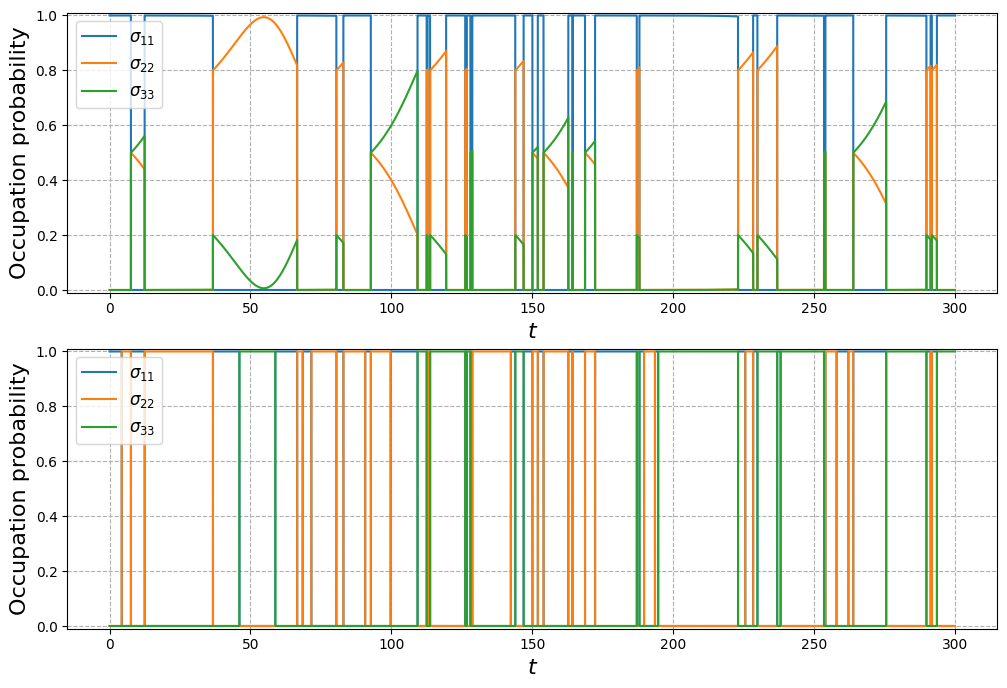

In [35]:
fig = plt.figure(figsize=(12, 8))

plt.subplot(211)
plt.plot(tlist, g1_evo_uni, label=r'$\sigma_{11}$')
plt.plot(tlist, g2_evo_uni, label=r'$\sigma_{22}$') 
plt.plot(tlist, g3_evo_uni, label=r'$\sigma_{33}$')

plt.xlabel(r'$t$', fontsize=16)
plt.ylabel('Occupation probability', fontsize=16)
plt.legend(fontsize=12, loc="upper left")
plt.grid(linestyle='--')
plt.ylim(-0.01, 1.01)

plt.subplot(212)

plt.plot(tlist, g1_evo_sec, label=r'$\sigma_{11}$')
plt.plot(tlist, g2_evo_sec, label=r'$\sigma_{22}$') 
plt.plot(tlist, g3_evo_sec, label=r'$\sigma_{33}$')

plt.xlabel(r'$t$', fontsize=16)
plt.ylabel('Occupation probability', fontsize=16)
plt.legend(fontsize=12, loc="upper left")
plt.grid(linestyle='--')

plt.ylim(-0.01, 1.01)

plt.show()

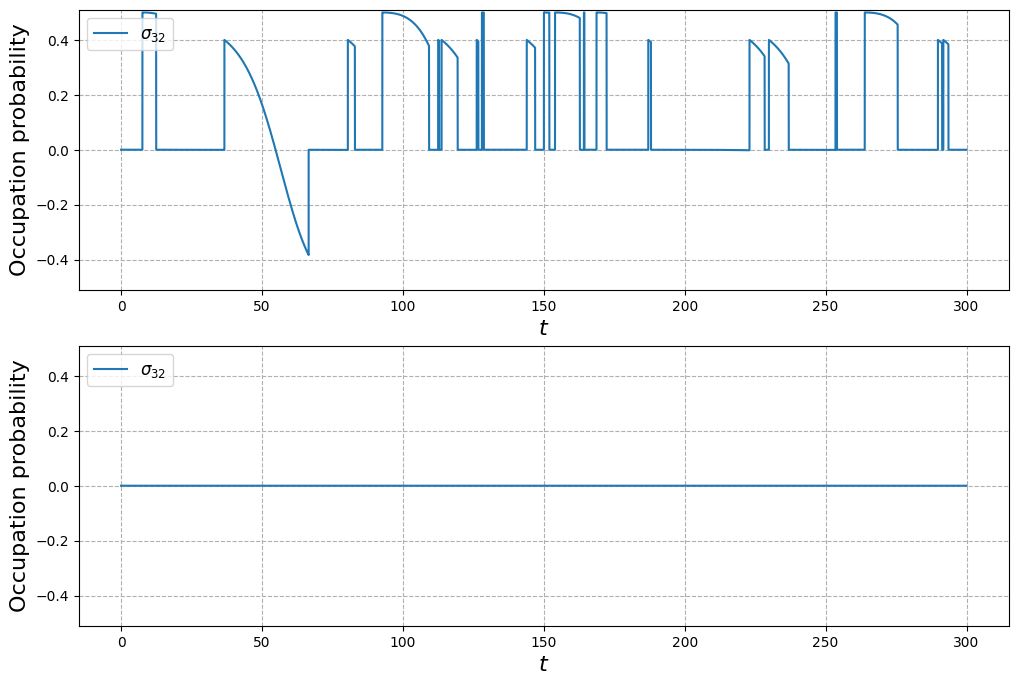

In [36]:
fig = plt.figure(figsize=(12, 8))

plt.subplot(211)
plt.plot(tlist, g32_evo_uni, label=r'$\sigma_{32}$')

plt.xlabel(r'$t$', fontsize=16)
plt.ylabel('Occupation probability', fontsize=16)
plt.legend(fontsize=12, loc="upper left")
plt.grid(linestyle='--')
plt.ylim(-0.51, 0.51)

plt.subplot(212)

plt.plot(tlist, g32_evo_sec, label=r'$\sigma_{32}$') 

plt.xlabel(r'$t$', fontsize=16)
plt.ylabel('Occupation probability', fontsize=16)
plt.legend(fontsize=12, loc="upper left")
plt.grid(linestyle='--')
plt.ylim(-0.51, 0.51)

plt.show()

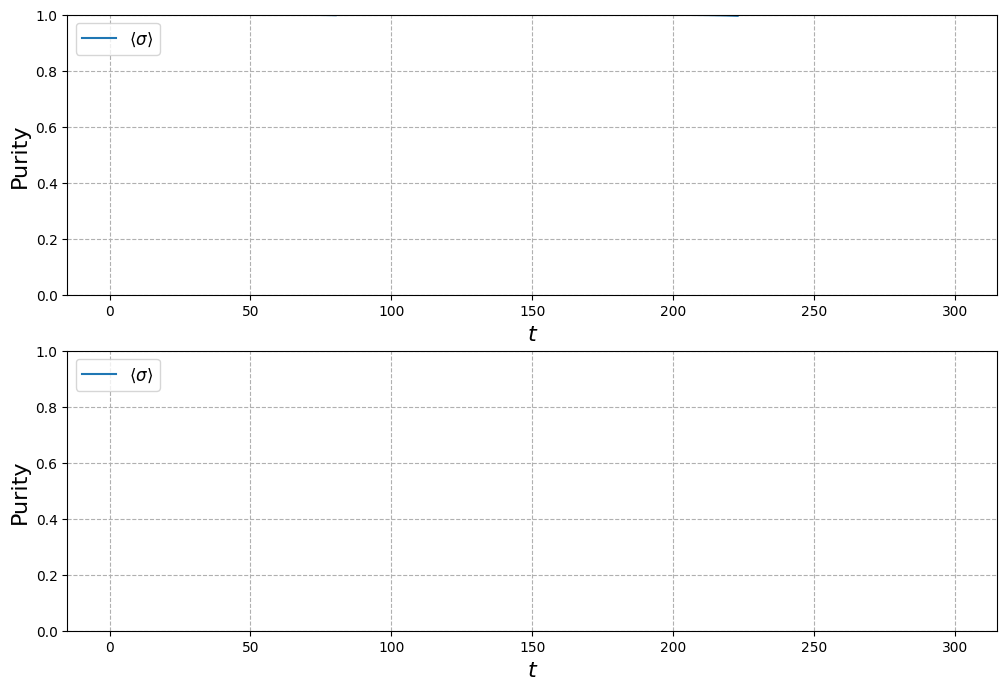

In [130]:
fig = plt.figure(figsize=(12, 8))

plt.subplot(211)
plt.plot(tlist, purity_uni, label=r'$\langle\sigma\rangle$')

plt.xlabel(r'$t$', fontsize=16)
plt.ylabel('Purity', fontsize=16)
plt.legend(fontsize=12, loc="upper left")
plt.grid(linestyle='--')
plt.ylim(-0, 1)

plt.subplot(212)

plt.plot(tlist, purity_sec, label=r'$\langle\sigma\rangle$') 

plt.xlabel(r'$t$', fontsize=16)
plt.ylabel('Purity', fontsize=16)
plt.legend(fontsize=12, loc="upper left")
plt.grid(linestyle='--')
plt.ylim(-0, 1)

plt.show()

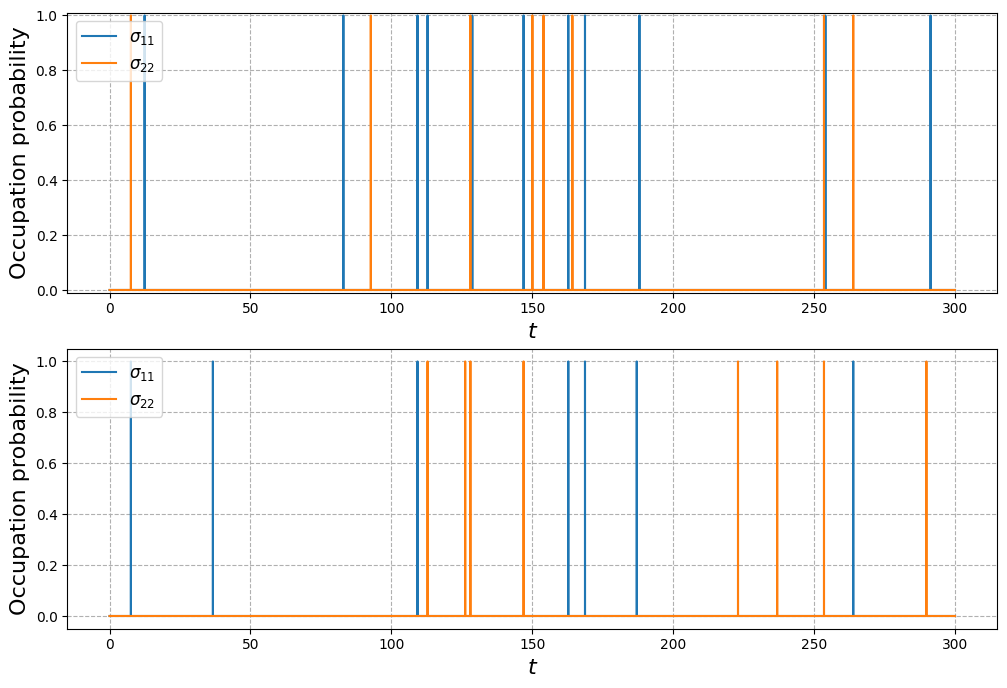

In [131]:
# Get measurement results
uni_currents = np.array([np.real(m)*dt for m in result_uni.measurement[0].T])
sec_currents = np.array([np.real(m)*dt for m in result_sec.measurement[0].T])

fig = plt.figure(figsize=(12, 8))

plt.subplot(211)
plt.plot(tlist, uni_currents[0], label=r'$\sigma_{11}$')
plt.plot(tlist, uni_currents[1], label=r'$\sigma_{22}$') 
plt.xlabel(r'$t$', fontsize=16)
plt.ylabel('Occupation probability', fontsize=16)
plt.legend(fontsize=12, loc="upper left")
plt.grid(linestyle='--')
plt.ylim(-0.01, 1.01)

plt.subplot(212)

plt.plot(tlist, sec_currents[0], label=r'$\sigma_{11}$') 
plt.plot(tlist, sec_currents[1], label=r'$\sigma_{22}$') 
plt.xlabel(r'$t$', fontsize=16)
plt.ylabel('Occupation probability', fontsize=16)
plt.legend(fontsize=12, loc="upper left")
plt.grid(linestyle='--')

# plt.ylim(-0.01, 1.01)

plt.show()

# Compute Power spectrum 

Here we compute the Power spectrum for both the Unified and Secular Master equations

In [132]:
# Create power spectrum 
omega0 = - 10
domega = 0.011
omega = np.arange(omega0, -omega0, domega)

S_uni = FCSPowerSpectrumLinear(H, c_ops_Unified, rho_ss_uni, omega, c_ops_Unified, [nu,-nu, 0,0], method='PD')
S_sec = FCSPowerSpectrumLinear(H, c_ops_Secular, rho_ss_sec, omega, c_ops_Secular, [nu,nu,-nu,-nu, 0, 0,0,0], method='PD')

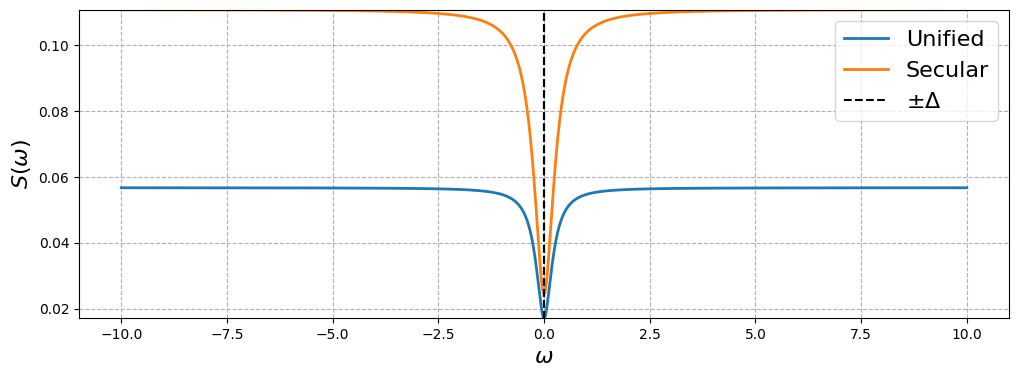

In [133]:
fig = plt.figure(figsize=(12, 4))

plt.plot(omega, S_uni, label='Unified', linewidth=2)
plt.plot(omega, S_sec, label='Secular', linewidth=2)
plt.grid(linestyle='--')
plt.xlabel(r'$\omega$', fontsize=16)
plt.ylabel(r'$S(\omega)$', fontsize=16)

plt.vlines([-delta, delta], 0, 1, linestyles='--', colors='k', label=r'$\pm \Delta$')

plt.ylim(np.min([S_sec, S_uni]), np.max([S_uni, S_sec]))
plt.legend(fontsize=16, loc="upper right")
# plt.yscale('log')
# plt.xscale('log')

plt.show()

# Compute P(n,t) from integrated current

We can compute the integrate $P(n,t)$ distribution for a fixed time $t$ and then estimate the cumulant generating function  $\lambda_{0}(\chi)$ by taking the inverse Fourier transform of this distribution
\begin{equation}
    \lambda_{0}(\chi) = t^{-1} \log \left(\int_{-\infty}^{\infty} dn e^{-i n \chi}P(n,t)\right)
\end{equation}
Let's do a simulation but with lots of trajectories and compute the integrated current 

In [14]:
# Now we to unravel the master equation 
t0, tf = 0, 200
dt = 0.1
tlist = np.arange(t0, tf, dt)

# define observables 
e_ops = [g1*g1.dag(), g2*g2.dag(), g3*g3.dag(), g3*g2.dag()]

# compute the solution, here the options ntraj is the number of trajectories and noise is the seed, store_measurement saves the jumps
result_uni = photocurrent_mesolve(H, rho_ss_uni, tlist, sc_ops=c_ops_Unified, e_ops=e_ops, ntraj=6000, noise=1, store_measurement=True)

10.0%. Run time:  11.62s. Est. time left: 00:00:01:44
20.0%. Run time:  23.14s. Est. time left: 00:00:01:32
30.0%. Run time:  34.65s. Est. time left: 00:00:01:20
40.0%. Run time:  46.15s. Est. time left: 00:00:01:09
50.0%. Run time:  57.86s. Est. time left: 00:00:00:57
60.0%. Run time:  69.61s. Est. time left: 00:00:00:46
70.0%. Run time:  81.46s. Est. time left: 00:00:00:34
80.0%. Run time:  93.30s. Est. time left: 00:00:00:23
90.0%. Run time: 105.19s. Est. time left: 00:00:00:11
Total run time: 117.00s


In [15]:
# Compute the particle currents
dNm = np.array(result_uni.measurement)[:, :, 0]*dt
dNp = np.array(result_uni.measurement)[:, :, 1]*dt
JL = np.real(np.cumsum(dNm - dNp, axis=1))

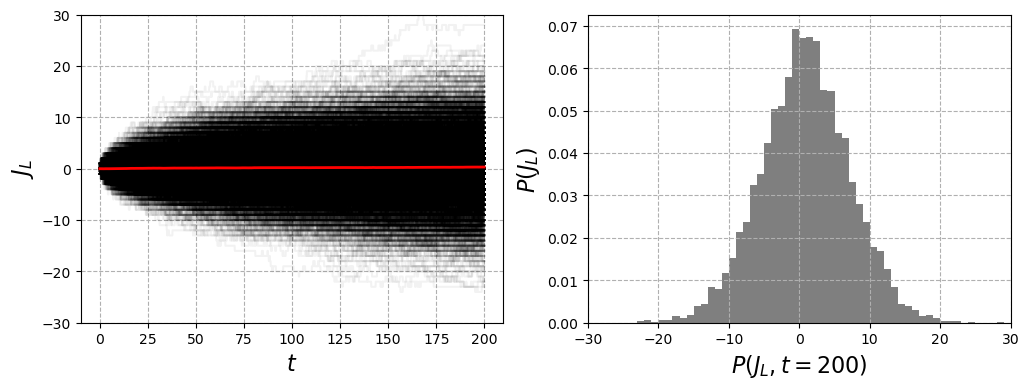

In [16]:
fig = plt.figure(figsize=(12, 4))

mx = 100

plt.subplot(121)
plt.plot(tlist, JL.T, 'k', alpha=0.05)
plt.plot(tlist, np.mean(JL, axis=0), 'r', linewidth=2)
plt.xlabel(r'$t$', fontsize=16)
plt.ylabel(r'$J_L$', fontsize=16)
plt.grid(linestyle='--')
plt.ylim(-30, 30)

plt.subplot(122)
(n, bins, patches) = plt.hist(JL[:, -1], bins=2*mx, density=True, color='k', alpha=0.5, range=(-mx, mx))
plt.xlabel(r'$P(J_L, t={})$'.format(tf), fontsize=16)
plt.ylabel(r'$P(J_L)$', fontsize=16)
plt.grid(linestyle='--')
plt.xlim(-30, 30)

plt.show()

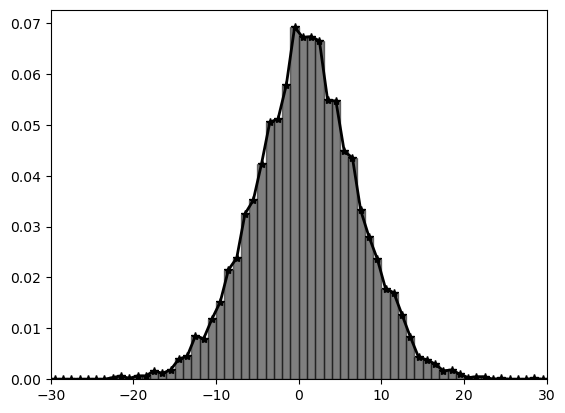

In [17]:
# compute average of bins with its adjacent bins
bin_avg = np.zeros(len(bins)-1)
for i in range(len(bins)-1):
    bin_avg[i] = (bins[i] + bins[i+1])/2


plt.plot(bin_avg, n, 'k-*', linewidth=2)
plt.hist(JL[:, -1], bins=2*mx, density=True, color='k', edgecolor='k', alpha=0.5, range=(-mx, mx))

plt.xlim(-30, 30)

plt.show()

In [18]:
# Compute chi values
k = len(n)
chis = np.linspace(-np.pi, np.pi, k)

# Compute lambda_0 
FPnt = np.array([np.dot(np.exp(1j*chi*bin_avg), n) for chi in chis])



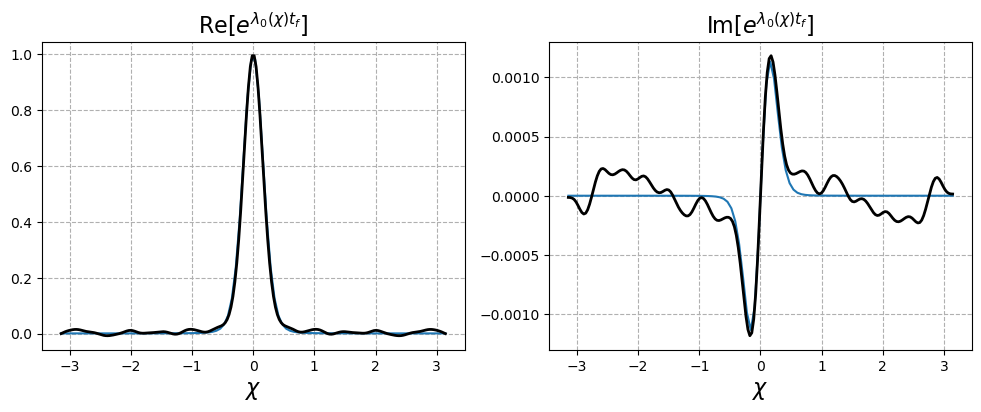

In [19]:
fig = plt.figure(figsize=(12, 4))

plt.subplot(121)
plt.plot(chi_list, np.real(np.exp(eigs_chi*tf)))
plt.plot(chis, np.real(FPnt), 'k', linewidth=2)
plt.grid(linestyle='--')
plt.xlabel(r'$\chi$', fontsize=16)
plt.title('Real part of the largest eigenvalue', fontsize=16)
plt.title(r'${\rm Re}[e^{\lambda_{0}(\chi) t_{f}}]$', fontsize=16)

plt.subplot(122)
plt.plot(chi_list,np.imag(np.exp(eigs_chi*tf)))
plt.plot(chis, np.imag(FPnt)/70, 'k', linewidth=2)
plt.grid(linestyle='--')
plt.xlabel(r'$\chi$', fontsize=16)
plt.title(r'${\rm Im}[e^{\lambda_{0}(\chi)t_{f}}]$', fontsize=16)

plt.show()